In [1]:
import sys
sys.path.append('..')

import config
import utils

import os
import pandas as pd
import numpy as np
import cv2
from tqdm import tqdm

### 1. Parse CSV annotations file

In [2]:
# Load data from csv file 
df_data = pd.read_csv(config.CSV_PATH)

In [3]:
def stringToImage(s):
    # Convert pixel values in string format to a np array
    image = np.array([int(x) for x in s.split(' ')]).reshape(48, 48)
    # Resize image to higher resolution
    image = cv2.resize(np.float32(image), dsize=(200, 200), interpolation=cv2.INTER_CUBIC)
    # Convert back to uint8
    image = np.uint8(image)
    # Convert from 1 channel to 3 channels
    return np.stack((image,)*3, axis=-1)
df_data[' pixels'] = df_data[' pixels'].apply(lambda s: stringToImage(s))

In [4]:
data_split = {
    'train': df_data[df_data[' Usage'] == 'Training'],
    'val': df_data[df_data[' Usage'] == 'PublicTest'],
    'test': df_data[df_data[' Usage'] == 'PrivateTest']
}

### 2. Data Pre-processing
Defining non-occlusion-aware data pre-processing
* Applying mathematical morphology
    - Binary opening to remove noise
    - Binary closing to close small holes inside foreground objects, or small black points on the object

In [5]:
def preprocess_step(image):
    kernel = np.ones((2, 2), np.uint8)
    opening = cv2.morphologyEx(image, cv2.MORPH_OPEN, kernel, iterations = 3)
    return cv2.morphologyEx(opening, cv2.MORPH_CLOSE, kernel, iterations = 3)

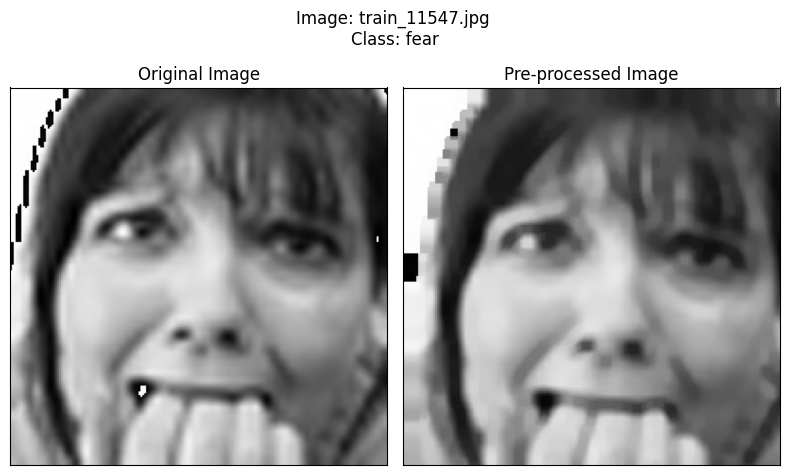

In [6]:
utils.plot_preprocess_step(data_split, 'train', preprocess_step)

### 3. Display Data Augmentation Example

In [7]:
import albumentations as A

augment_tf = A.Compose([
    A.Rotate(limit=20, border_mode=cv2.BORDER_REPLICATE),
    A.Affine(shear=(-20, 20), mode=cv2.BORDER_REPLICATE),
    A.HorizontalFlip(),
    A.RandomScale(scale_limit=0.2),
    A.Affine(translate_percent=(-0.2, 0.2), mode=cv2.BORDER_REPLICATE),
    A.Resize(height=200, width=200, interpolation=cv2.INTER_CUBIC),
])

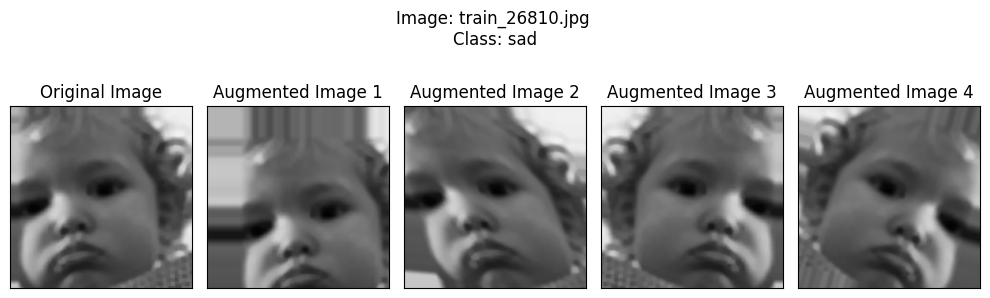

In [8]:
utils.plot_augmentation(data_split, 'train', augment_tf, preprocess_step)      

### 4. Parse data to disk

In [9]:
def parse_data(data_split):
    '''
    Write data in Dataframe to disk, optionally apply data augmentation 'transform', 'augment_iterations' times to data 
    Arguments:
        data_split (dictionary) - dictionary containing key-value pairs of dataset split (string) and Dataframe of split
    '''
    for ttv, data in data_split.items():
        images = data[' pixels'].tolist()
        labels = data['emotion'].tolist()
        out_labels = []
        
        # Write images to disk
        image_idx = 0
        loop = tqdm(enumerate(images), total=len(images), leave=True)
        for idx, image in loop:
            loop.set_description(f'Writing {ttv} dataset to disk')
            
            # Apply preprocessing step
            image = preprocess_step(image)
                
            # Write image to disk
            image_path = os.path.join(config.DATA_PATH, ttv, str(ttv) + '_' + str(image_idx) + '.jpg')
            cv2.imwrite(image_path, image)
            out_labels.append(labels[idx])
            image_idx += 1
            
        # Write labels to disk
        np.save(os.path.join(config.DATA_PATH, 'annotations', str(ttv) + '_' + 'labels.npy'), out_labels)   

In [10]:
""" 
Requires file structure
    /data
        /FER-2013
            /train
            /val
            /test
            /annotations
            /icml_face_data.csv
"""

parse_data(data_split)

Writing test dataset to disk: 100%|██████████| 3589/3589 [00:09<00:00, 374.34it/s]
